# Brain Tumor Classification Project

In [1]:
# import necessary libraries

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator, array_to_img
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Dense,Conv2D,Dropout,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix    


In [8]:
# Check dataset directories  
train_dir="C:/Users/User/Desktop/projekti_zadnje/klasifikacija_tumora/Crop-Brain-MRI/"
test_dir="C:/Users/User/Desktop/projekti_zadnje/klasifikacija_tumora/Test-Data/"
print(os.listdir(train_dir))
print(os.listdir(test_dir))


['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [9]:
# check number of images in every class/train data

print('Number of glioma tumor images: ',len(os.listdir(train_dir+'glioma_tumor/')))
print('Number of meningioma tumor images: ',len(os.listdir(train_dir+'meningioma_tumor/')))
print('Number of no tumor images: ',len(os.listdir(train_dir+'no_tumor/')))
print('Number of pituitary tumor images: ',len(os.listdir(train_dir+'pituitary_tumor/')))

Number of glioma tumor images:  926
Number of meningioma tumor images:  937
Number of no tumor images:  501
Number of pituitary tumor images:  901


In [10]:
# check number of images in every class/test data

print('Number of glioma tumor images: ',len(os.listdir(test_dir+'glioma_tumor/')))
print('Number of meningioma tumor images: ',len(os.listdir(test_dir+'meningioma_tumor/')))
print('Number of no tumor images: ',len(os.listdir(test_dir+'no_tumor/')))
print('Number of pituitary tumor images: ',len(os.listdir(test_dir+'pituitary_tumor/')))

Number of glioma tumor images:  5
Number of meningioma tumor images:  5
Number of no tumor images:  5
Number of pituitary tumor images:  5


In [11]:
classes=os.listdir(train_dir) # saves a list of class names
files_path_dict={}      # key is class name and value is list of all the file names contained in particular class folder
for c in classes:
  files_path_dict[c]=list(map(lambda x :train_dir+c+'/'+x,os.listdir(train_dir+c)))  # lambda function to access all the file names in particular class



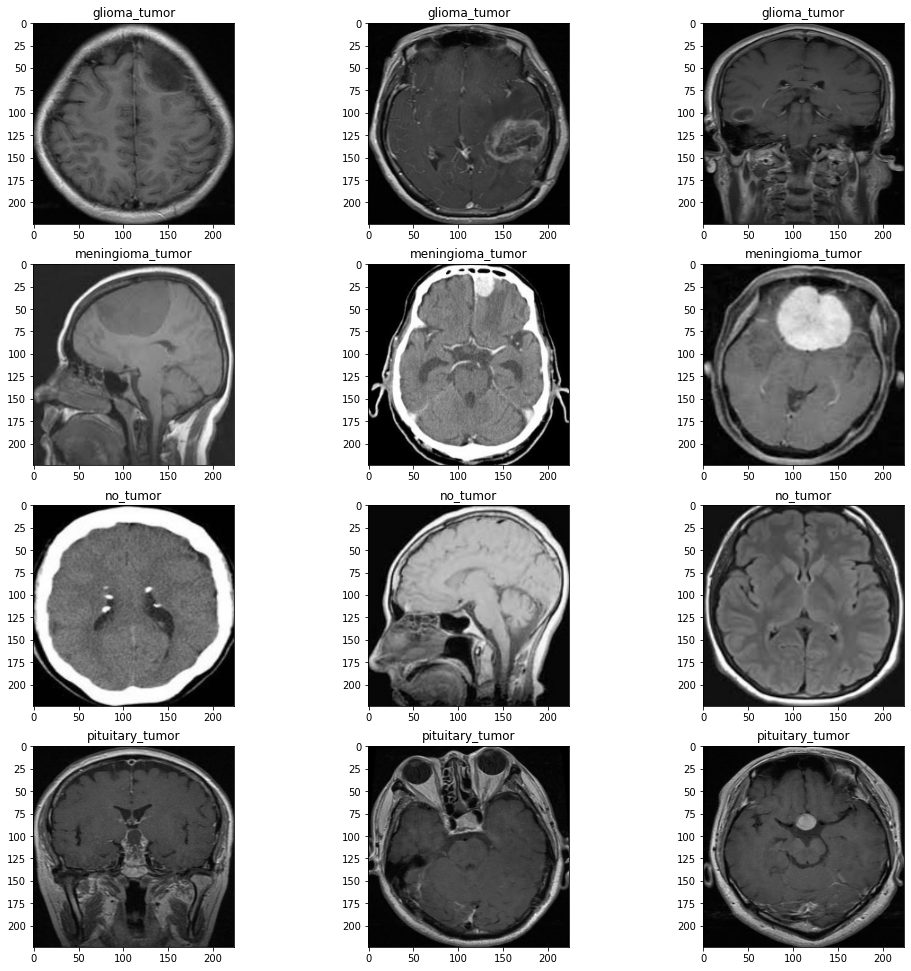

In [12]:
#   data visualization

plt.figure(figsize=(17,17))
index=0
for c in classes:
  random.shuffle(files_path_dict[c])   #  random image is shown from folder
  path_list=files_path_dict[c][:4]   # first 4 files only

  for i in range(1,4):  
    index+=1
    plt.subplot(4,3,index)  # 4 row, 3 column
    plt.imshow(load_img(path_list[i]))  # using load_img from tf library
    plt.grid(False)
    plt.title(c)

In [13]:
# image datagenerator
# perform data augmentation and prepare the train, validation and test dataset
# generates batches of tensor image data with real-time data augmentation

datagen= ImageDataGenerator(rotation_range=10,height_shift_range=0.2,horizontal_flip=True,validation_split=0.25)
train_data=datagen.flow_from_directory(train_dir,
                                       target_size=(224,224),
                                       batch_size=32,       # number of images to be yielded from the generator per batch
                                       class_mode='categorical',    # set binary if you have only two classes to predict, if not set to categorical
                                       subset='training')

                                      
valid_data=datagen.flow_from_directory(train_dir,
                                       target_size=(224,224),
                                       batch_size=32,
                                       shuffle=False,    # if you shuffle, conf.matrix will not be correct
                                       class_mode='categorical',
                                       subset='validation')
test_datagen=ImageDataGenerator() 
test_data=test_datagen.flow_from_directory(test_dir,
                                      target_size=(224,224),
                                      shuffle=False,
                                      class_mode='categorical')

Found 2450 images belonging to 4 classes.
Found 815 images belonging to 4 classes.
Found 20 images belonging to 4 classes.


<function matplotlib.pyplot.show(close=None, block=None)>

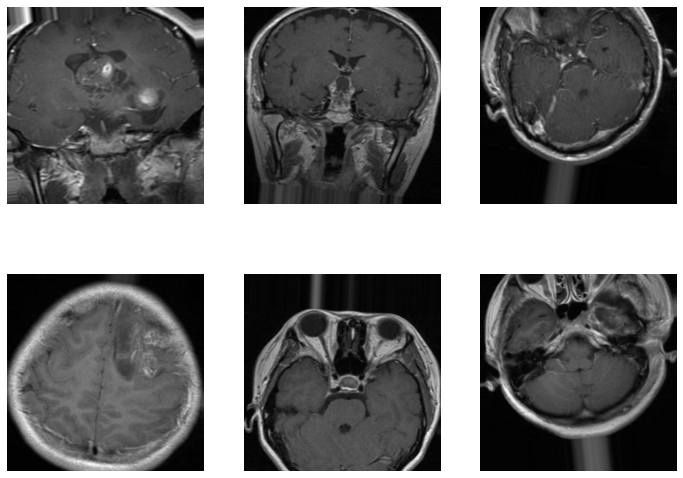

In [14]:
# view the augmented data.

sample_x,sample_y=next(train_data)  # batch of train data
plt.figure(figsize=(12,9))
for i in range(6):
  plt.subplot(2,3,i+1)
  sample=array_to_img(sample_x[i])
  plt.axis('off')
  plt.grid(False)
  plt.imshow(sample)
plt.show

In [22]:
# build and compile the model
effnet=EfficientNetB0(weights='imagenet',include_top=False,input_shape=(224,224,3))

# This model takes input images of shape (224, 224, 3)
#  Normalization is included as part of the model
#  excluded the final Dense layer (include_top=False) and added my layers with 4 neurons in final layer --> 4 classes
# https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
model=effnet.output
model=GlobalAveragePooling2D()(model)
model=Dropout(0.5)(model)
model=Dense(4,activation='softmax')(model)
model=Model(inputs=effnet.input,outputs=model)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 224, 224, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization_2 (Normalization) (None, 224, 224, 3)  7           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_2[0][0]            
____________________________________________________________________________________________

In [17]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
# Use this crossentropy loss function when there are two or more label classes

# define callbacks
checkpoint=ModelCheckpoint('naj_tezine_braintumor.h5',monitor='val_accuracy',save_weights_only=True,mode='auto',verbose=1) 
 #save only when vall_acc is improving
earlystop=EarlyStopping(monitor='val_accuracy',patience=5,mode='auto',verbose=1)  # will stop training if vall_acc is not improving for 5 epochs

In [ ]:
# train the model
history=model.fit(train_data,epochs=20,validation_data=valid_data,verbose=1,callbacks=[checkpoint,earlystop])


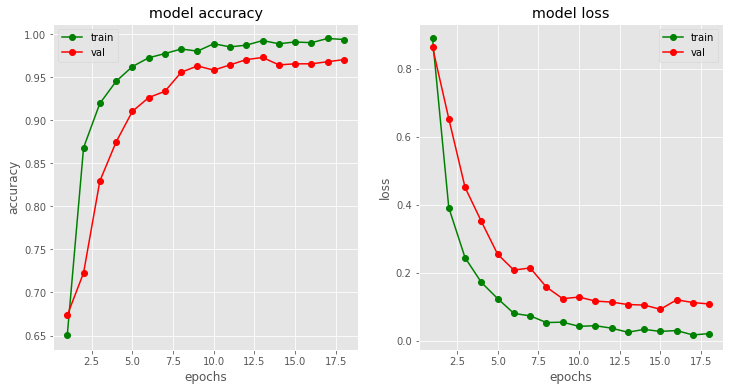

In [41]:
# plot the training curves

plt.style.use('ggplot')
plt.figure(figsize=(12,6))
epochs=range(1,19)            #  range must be (1,x) , where x is the number of trained epochs +1
plt.subplot(1,2,1)
plt.plot(epochs,history.history['accuracy'],'go-')
plt.plot(epochs,history.history['val_accuracy'],'ro-')
plt.title('model accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train','val'],loc='upper left')

plt.subplot(1,2,2)
plt.plot(epochs,history.history['loss'],'go-')
plt.plot(epochs,history.history['val_loss'],'ro-')
plt.title('model loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','val'],loc='upper right')
plt.show()




In [36]:
# evaluate the model on test set

print("Evaluate on test data")
results = model.evaluate(test_data)          
print("test loss, test acc:", results)

Evaluate on test data
1/1 [==============================] - 1s 996ms/step - loss: 0.0104 - accuracy: 1.0000
test loss, test acc: [0.010357679799199104, 1.0]


In [19]:
#  confusion matrix on validation data
 

Y_pred = model.predict_generator(valid_data)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
y_true=valid_data.classes
print(confusion_matrix(y_true, y_pred))

C:\Users\pc\anaconda3\envs\AIOpenCV\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[228   2   0   1]
 [  2 230   1   1]
 [  0   0 124   1]
 [  0   0   0 225]]


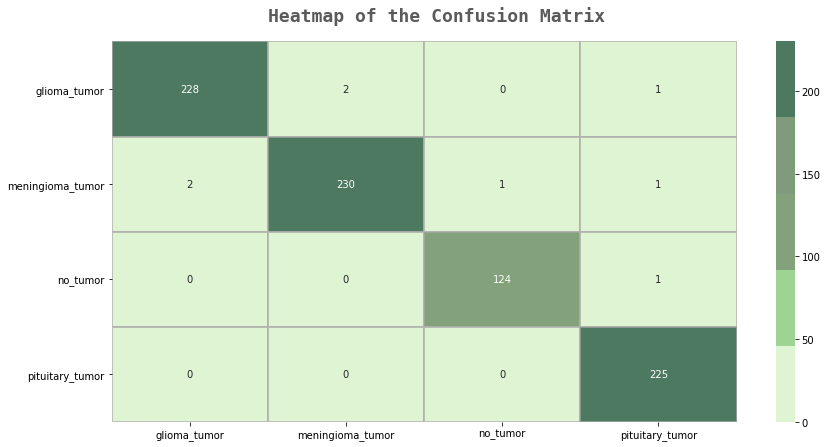

In [20]:
#  seaborn heatmap of confusion matrix

colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

#sns.palplot(colors_dark)
#sns.palplot(colors_green)
#sns.palplot(colors_red)

labels = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']


fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_true,y_pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3],fmt='d')    #  put fmt='d' for TP to be shown as integers and not scientific numbers
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',                         
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

In [8]:
# classification report
print(classification_report(valid_data.classes, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       231
           1       0.99      0.99      0.99       234
           2       0.99      0.99      0.99       125
           3       0.99      1.00      1.00       225

    accuracy                           0.99       815
   macro avg       0.99      0.99      0.99       815
weighted avg       0.99      0.99      0.99       815



In [18]:
#  inference mode, load weights for future classification tasks, before loading weights, you must rerun cells with model build and compile it
# then predict on image

model.load_weights("naj_tezine_braintumor.h5")

84.38276648521423% Confidence  glioma_tumor


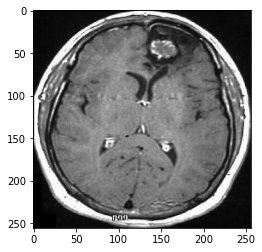

In [29]:
# obtain predictions on Test Images

class_dict={0: 'glioma_tumor',1: 'meningioma_tumor',2: 'no_tumor',3: 'pituitary_tumor'}

test_img1=cv2.imread("C:/Users/AI lipik/Desktop/Content/Test-Data/glioma_tumor/3.jpg")
plt.imshow(test_img1)
plt.grid(False)
test_img1=cv2.resize(test_img1,(224,224))
test_img1=np.expand_dims(test_img1,axis=0)
pred=model.predict(test_img1)
classification = np.where(pred == np.amax(pred))[1][0]
print(str(pred[0][classification]*100) + ' % Confidence  ' + class_dict[classification])